---
###07 LightGBM

-  XGboost보다 학습에 걸리는 시간이 훨씬 적고 메모리 사용량도 상대적으로 적음
- XGboost와 예측 성능의 차이가 별로 없음.
- 리프 중심 트리 분할 방식을 사용해 트리의 균형을 맞추지 않고, 최대 손실 값을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고 비대칭적인 규칙 트리가 생성

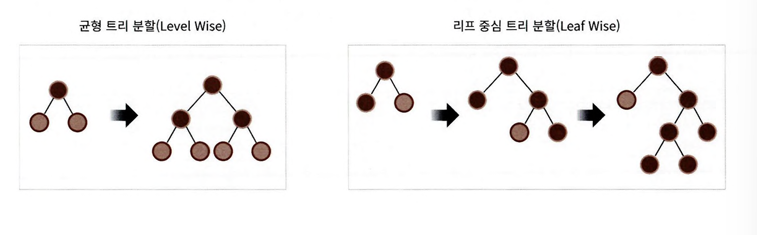

- LIgthGBM의 장점
  - 더 빠른 학습과 예측 수행 시간.
  - 더 작은 메모리 사용량.
  - 카테고리형 피처의 자동 변환과 최적 분할(원-핫 인코딩 등을 사용하지 않고도 카테고리형 피처를 최적으로 변환하고 이에 따른 노드 분할 수행)

- LIghtGBM 설치


In [1]:
!pip install lightgbm==3.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.4 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0


In [2]:
import lightgbm
from lightgbm import LGBMClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


- LIghtGBM 하이퍼 파라미터
  
  주요 파라미터
    - num_iterations [default=100]: 반복 수행하려는 트리의 개수를 지정, 크게 지정할수록 예측 성능이 높아질 수 있으나, 너무 크게 지정하면 오히려 과적합으로 성능이 저하될 수 있음, 사이킷런 GBM과 XGboost의 사이킷런 호환 클래스의 n_estimators와 같은 파라미터이므로 LIgthGBM의 사이킷런 호환 클래스에서는 n_estimators로 이름이 변경
    - learning_rate [default=0.1]: 0에서 1사이의 값을 지정하며 부스팅 스텝을 반복적으로 수행할 때 업데이트되는 학습률 값, 일반적으로 n_estimators를 크게하고 learning_rate를 작게해서 예측 성능을 향상시킬 수 있으나, 마찬가지로 과적합 이슈와 학습 시간이 길어지는 부정적인 영향도 고려해야 함, GBM, XGboost의 learning_rate와 같은 파라미터임.
    - max_depth [default=-1]: 트리 기반 알고리즘의 max_depth와 같음, 0보다 작은 값을 지정하면 깊이에 제한이 없음, depth wise 방식의 트리와 다르게 LIghtGBM은 Leaf wise 기반이므로 깊이가 상대적으로 더 깊어짐.
    - min_data_in_leaf [default=20]: 결정 트리의 min_sample_leaf와 같은 파라미터이지만, 사이킷런 래퍼 LIgthGBM 클래스인 LIghtGBMClassifier에서는 min_child_samples 파라미터로 이름이 변경, 최종 결정 클래스인 리프 노드가 되기 위해서 최소한으로 필요한 레코드 수이며 과적합을 제어하기 위한 파라미터임.




- 하이퍼 파라미터 튜닝 방안
  - num_leaves는 개별 트리가 가질수 있는 최대 리프의 개수이고 LIgthGBM 모델의 복잡도를 제어하는 주요 파라미터임, 일반적으로 num_leaves의 개수를 높이면 정확도가 높아지지만, 반대로 트리의 깊이가 깊어지고 모델이 복잡도가 커져 과적합 영향도가 커짐.
  - min_data_in_leaf는 사이킷런 래퍼 클래스에서는 min_child_samples로 이름이 바뀜, 과적합을 개선하기 위한 중요한 파라미터임, num_leaves와 학습 데이터의 크기에 따라 달라지지만, 보통 큰 값으로 설정하면 트리가 깊어지는 것을 방지.
  - max_depth는 명시적으로 깊이의 크기를 제한, num_leaves, min_data_in_leaf와 결합해 과적합을 개선하는데 사용
  

- 파이썬 래퍼 LIghtGBM과 사이킷런 래퍼 XGBoost, LightGBM 하이퍼 파라미터 비교
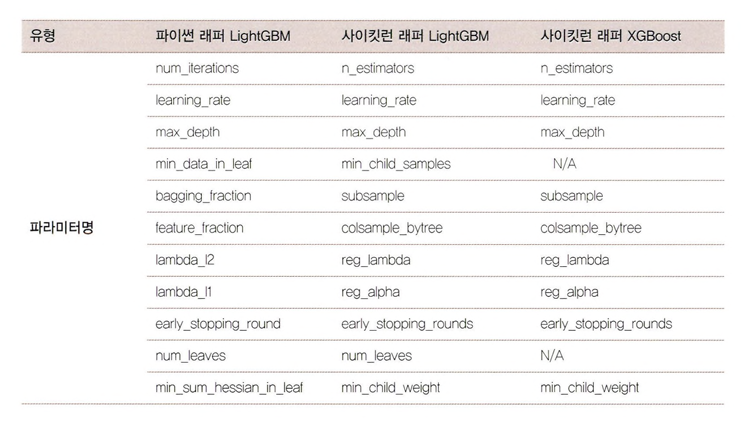

- LightGBM 적용 - 위스콘신 유방암 예측

In [3]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target'] = dataset.target
X_features = cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:,-1]

# 전체 데이터 중 88%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

# 앞서 XGBoost와 동일하게 n_estimaors는 400 설정.
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# LigthGBM도 XGboost와 동일하게 조기 중단 수행 가능
evals=[(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',
                 eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba_po=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba_po)

    print("오차 행렬")
    print(confusion)
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

In [5]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1: 0.9677, AUC: 0.9877


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

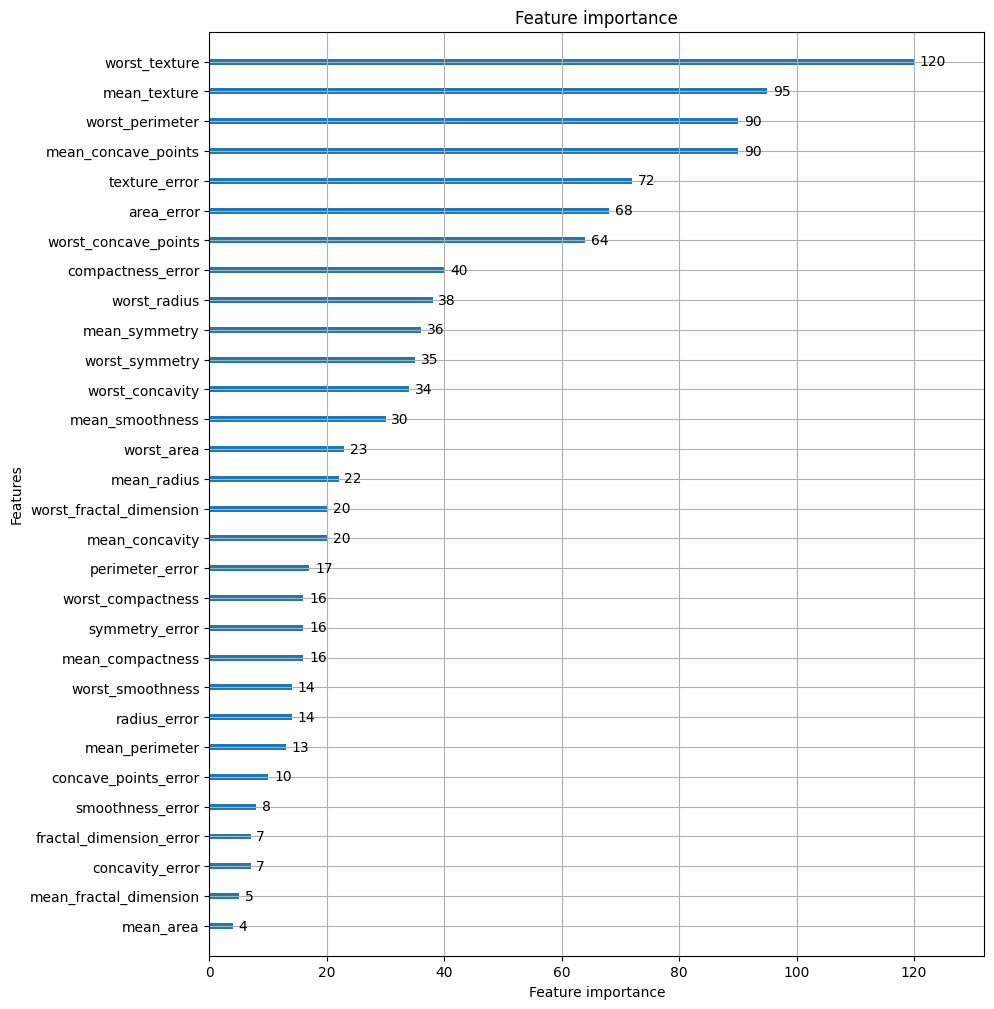

In [6]:
# plot_importance()를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)

---
### 08 베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝


In [7]:
# LIghtGBM의 6가지 하이퍼 파라미터를 최적화하려는 시도를 한다고 가정
params = {
    'max_depth': [10, 20, 30, 40, 50],
    'num_leaves': [35, 45, 55, 65],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'min_child_weight': [10, 20, 30, 40],
    'reg_alpha': [0.01, 0.05, 0.1]
}

*  베이지안 최적화 개요
   - 목적 함수 식을 제대로 알 수 없는 블랙 박스 형태의 함수에서 최대 또는 최소 함수 반환 값을 만드는 최적 입력값을 가능한 적은 시도를 통해 빠르고 효과적으로 찾아주는 방식
   -  베니지안 최적화 단계
   1. 최초에는 랜덤하게 하이퍼 파라미터들을 샘플링하고 성능 결과를 관측, 아래 그림에서 검은색 원은 특정 하이퍼 파라미터가 입력되었을 때 관측된 성능 지표 결괏값을 뜻하며 주황색 사선을 찾아야 할 목표 최적 함수임.
   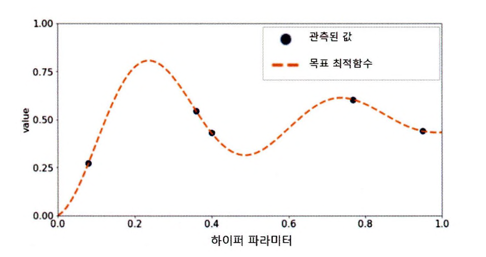

  2. 관측된 값을 기반으로 대체 모델은 최적 함수를 추청. 아래 그림에서 파란색 실선을 대체 모델이 추정한 최적 함수이며 옅은 파란색으로 되어 있는 영역은 예측된 함수의 신뢰 구간임. 추정된 함수의 결괏값 오류 펀치를 의미하며 추정 함수의 불확실성을 나타냄. 최적 관측값은 y축 value에서 가장 높은 값을 가질 떄의 하이퍼 파라미터임.
  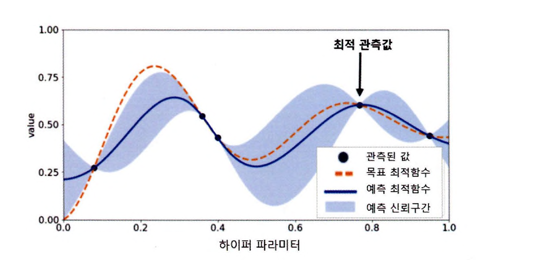

3. 추정된 최적 함수를 기반으로 획득 함수는 다음으로 관측할 하이퍼 파라미터 값을 계산, 획득함수는 이전의 최적 관측값보다 더 큰 최댓값을 가질 가능성이 높은 지점을 찾아서 다음에 관츨할 하이처 하라미터를 대체 모델에 전달

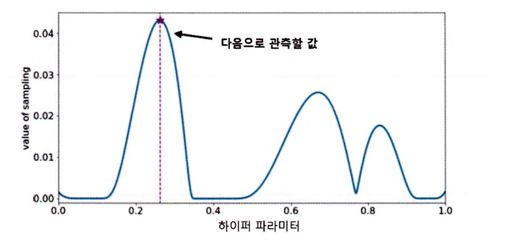

4. 획득 함수로부터 전달된 하이퍼 파라미터를 수행하여 관측된 값을 기반으로 대체 모델은 갱신되어 다시 최적 함수 예측 추정

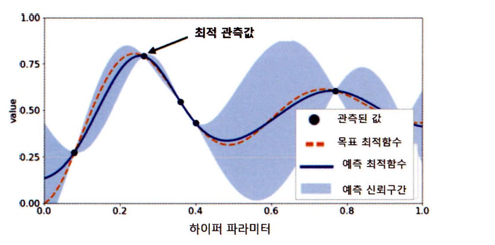

- HyperOpt 사용하기

In [8]:
!pip install hyperopt

  주요 로직
    

    *   입력 변수명과 입력값의 검색 공간(Search Space)설정
    *  목적 함수(Objective Function)
    *  목적 함수의 반환 최솟값을 가지는 최적 입력값을 유추하는 것






In [9]:
from hyperopt import hp

# -10 ~ 10까지 1간격을 가지는 입력 변수 x와 -15 ~ 15까지 1간격으로 입력 변수 y 설정
search_space = {'x': hp.quniform('x', -10, 10, 1), 'y': hp.quniform('y', -15, 15, 1)}

low: 최솟값, high: 최댓값 q: 간격
-  hp.quniform(label, low, high, q): label로 지정된 입력값 변수 검색 공간을 최솟값 low에서 최댓값 high까지 q의 간격을 가지고 설정
- hp.uniform(label, low, high): 최솟값 low에서 최댓값 high까지 정규 분포 형태의 검색 공간 설정
- hp.randint(label, upper): 0부터 최댓값 upper까지 random한 정수값으로 검색 공간 설정
- hp.logunoform(label, low, high): exp(uniform(low, high))값을 반환하며, 반환 값의 log 변환된 값은 정규 분포 형태를 가지는 검색 공간 설정
- hp.choice(label, options): 검색 값이 문자열 또는 문자열과 숫자값이 섞여 있을 경우 설정, Options는 리스트나 튜플 형태로 제공되며 hp.choice('tree_critierion',['gini','entropy'])와 같이 설정하면 입력 변수 tree_criterion의 값을 'gini'와 'entropy'로 설정하여 입력


In [10]:
from hyperopt import STATUS_OK

# 목적 함수를 생성, 변숫값과 변수 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환
def objective_func(search_space):
  x = search_space['x']
  y = search_space['y']
  retval = x**2 - 20*y
  return retval

fmin() 함수의 주요 인자
-  fn: 위에서 생성한 objective_func와 같은 목적 함수
- space: 위에서 생성한 search_space와 같은 검색 공간 딕셔너리
- algo: 베이지안 최적화 적용 알고리즘 입니다. 기본적으로 tpe.suggest이며 이는 HyperOpt의 기본 최적화 알고리즘
- max_evals: 최적 입력값을 찾기 위한 입력값 시도 횟수
- trials: 최적 입력값을 찾기 위해 시도한 입력값 및 해당 입력값의 목적 함수 반환값 결과를 저장하는 데 사용
- rstate: fmin()을 수행할 때마다 동일한 결괏값을 가질 수 있도록 설정하는 랜덤 시드(seed) 값

In [11]:
from hyperopt import fmin, tpe, Trials
# 입력 결괏값을 저장한 Trials 객체값 생성
trial_val = Trials()

# 목적 함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도(max_evals=5)로 찾아냄
best_01 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5,
               trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_01)

100%|██████████| 5/5 [00:00<00:00, 156.36trial/s, best loss: -224.0]
best: {'x': -4.0, 'y': 12.0}


In [12]:
trial_val = Trials()

# max_evals를 20회로 늘려서 재테스트
best_02 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20,
               trials=trial_val, rstate=np.random.default_rng(seed=0))
print('best:', best_02)

100%|██████████| 20/20 [00:00<00:00, 497.16trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


In [13]:
# fmin()에 인자로 들어가는 Trials 객체의 result 속성에 파이선 리스트로 목적 함수 반환 값들이 저장됨
# 리스트 내부의 개별 원소는 '{loss': 함수 변환 값, 'status': 반환 상태값}와 같은 딕셔너리임.
print(trial_val.results)

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


In [14]:
# Trials 객체의 vals 속성에 {'입력변수명': 개별 수행 시마다 입력된 값 리스트} 형태로 저장
print(trial_val.vals)

{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0]}


In [15]:
import pandas as pd

# results에서 loss 키 값에 해당하는 벨류들을 추출하여 list로 생성
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

# DataFrame으로 생성.
result_df = pd.DataFrame({'x': trial_val.vals['x'], 'y': trial_val.vals['y'], 'losses': losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


* HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화


In [16]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
# 앞에서 추출한 학습 데이터를 다시 학습과 검증 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

In [17]:
from hyperopt import hp

# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색.
xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 20,1),
                    'min_child_weight': hp.quniform('min_child_weight', 1,2,1),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),}

In [18]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임.
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함.
# 정확도는 높을수록 더 좋은 수치임, -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
    # 수행 시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                          min_child_weight=int(search_space['min_child_weight']),
                          learning_rate=search_space['learning_rate'],
                          colsample_bytree=search_space['colsample_bytree'],
                          eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)

  # accuracy는 cv=3만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1 곱함
    return {'loss':-1*np.mean(accuracy), 'status':STATUS_OK}

In [19]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정
            trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best:', best)

100%|██████████| 50/50 [00:47<00:00,  1.04trial/s, best loss: -0.9670616939700244]
best: {'colsample_bytree': 0.5026505409854508, 'learning_rate': 0.19828428817109603, 'max_depth': 15.0, 'min_child_weight': 1.0}


In [20]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2},  min_child_weight：{3}'.format(
round(best['colsample_bytree'], 5), round(best['learning_rate'], 5),
int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.50265, learning_rate:0.19828, max_depth:15,  min_child_weight：1


In [25]:
!pip install --upgrade xgboost


  Using cached xgboost-2.1.1-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.1-py3-none-manylinux_2_28_x86_64.whl (153.9 MB)
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.6.1
    Uninstalling xgboost-1.6.1:
      Successfully uninstalled xgboost-1.6.1


In [29]:

xgb_wrapper = XGBClassifier(n_estimators=400,
                            learning_rate=round(best['learning_rate'], 5),
                            max_depth=int(best['max_depth']),
                            min_child_weight=int(best['min_child_weight']),
                            colsample_bytree=round(best['colsample_bytree'],5),
                            eval_metric='logloss',
                            early_stopping_rounds=50,
                            verbose=True
)

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, eval_set=evals)
preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)


[0]	validation_0-logloss:0.51230	validation_1-logloss:0.55948
[1]	validation_0-logloss:0.40697	validation_1-logloss:0.47575
[2]	validation_0-logloss:0.32809	validation_1-logloss:0.41760
[3]	validation_0-logloss:0.27049	validation_1-logloss:0.37988


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [04:12:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-logloss:0.22671	validation_1-logloss:0.34438
[5]	validation_0-logloss:0.19305	validation_1-logloss:0.31788
[6]	validation_0-logloss:0.16589	validation_1-logloss:0.30717
[7]	validation_0-logloss:0.14300	validation_1-logloss:0.30056
[8]	validation_0-logloss:0.12355	validation_1-logloss:0.29707
[9]	validation_0-logloss:0.10737	validation_1-logloss:0.28298
[10]	validation_0-logloss:0.09355	validation_1-logloss:0.26801
[11]	validation_0-logloss:0.08250	validation_1-logloss:0.26738
[12]	validation_0-logloss:0.07357	validation_1-logloss:0.26220
[13]	validation_0-logloss:0.06572	validation_1-logloss:0.26240
[14]	validation_0-logloss:0.05892	validation_1-logloss:0.25570
[15]	validation_0-logloss:0.05247	validation_1-logloss:0.25186
[16]	validation_0-logloss:0.04804	validation_1-logloss:0.24924
[17]	validation_0-logloss:0.04336	validation_1-logloss:0.24016
[18]	validation_0-logloss:0.03953	validation_1-logloss:0.23794
[19]	validation_0-logloss:0.03585	validation_1-logloss:0.2362

---
### 11 스태깅 앙상블

-  스태깅(stacking)은 개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출
- 개별적인 기반 모델, 이 개별 기반 모델의 예측 데이터를 학스 데이터로 만들어서 학습하는 최종 메타 모델
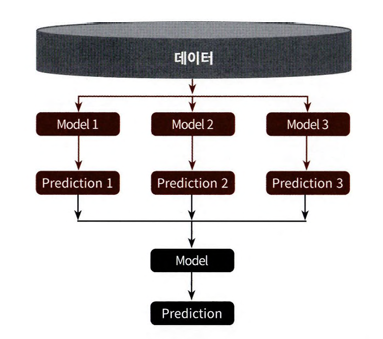

- 모델별로 도출된 예측 헤이블 값을 다시 합해서 새로운 데이터 세트를 만들고 이렇게 스태깅된 데이터 세트에 대해 최종 모델을 적용해 최종 예측을 하는 것이 스태깅 앙상블 모델
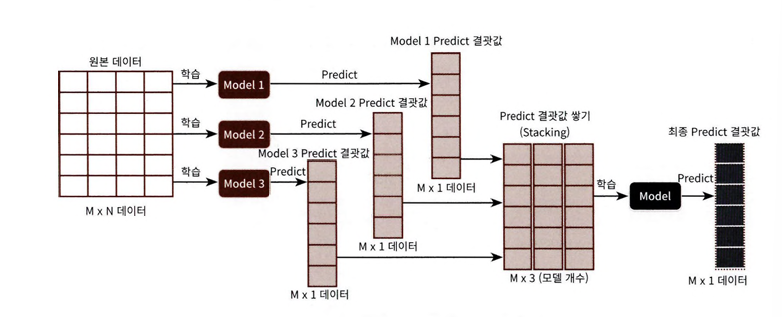

-  기본 스태깅 모델

In [73]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train , X_test , y_train , y_test = train_test_split(X_data , y_label , test_size=0.2 , random_state=0)


In [74]:
# 개별 ML 모델을 위한 Classifier 생성.
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 Stacking 모델을 위한 Classifier생성.
lr_final = LogisticRegression(C=10)

In [75]:
# 개별 모델들을 학습.
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train , y_train)
dt_clf.fit(X_train , y_train)
ada_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(n_estimators=100)

In [76]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정.
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f} '.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561 


In [77]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦.
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [78]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test , final)))

최종 메타 모델의 예측 정확도: 0.9737


*  CV 세트 기반의 스태깅

  1. 각 모델별로 원본 학습/테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터를 생성
  2. 개별 모델들이 생성한 학습용 데이터를 모두 스태깅 형태로 합쳐서 메타 모델이 학습할 최종 학습용 데이터 세트를 생성, 마찬가지로 각 모델들이 생성한 테스트용 데이터를 모두 스태깅한 혀앹로 합쳐서 메타 모델이 예측할 최종 테스트 데이터 세트를 생성, 메타 모델은 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이블 데이터를 기반으로 학습한 뒤, 최종적으로 생성된 테스트 데이터 세트를 예측하고 원본 테스트 데이터의 레이블 데이터를 기반으로 평가

  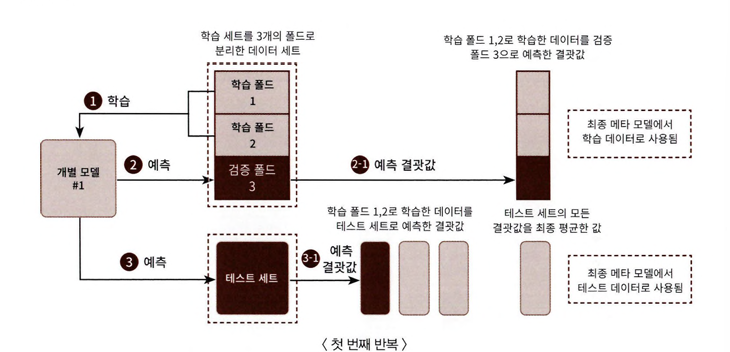

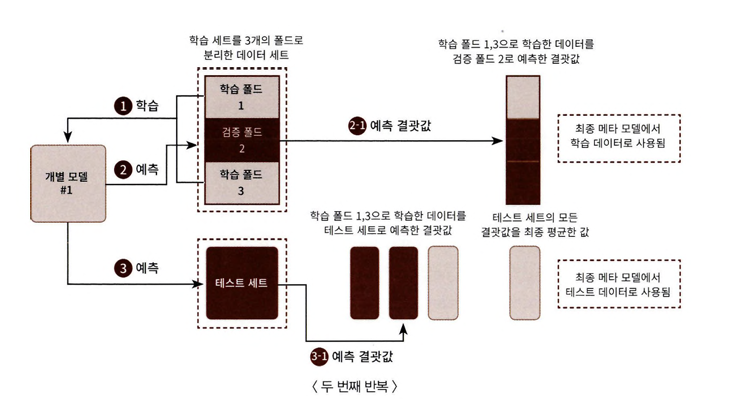

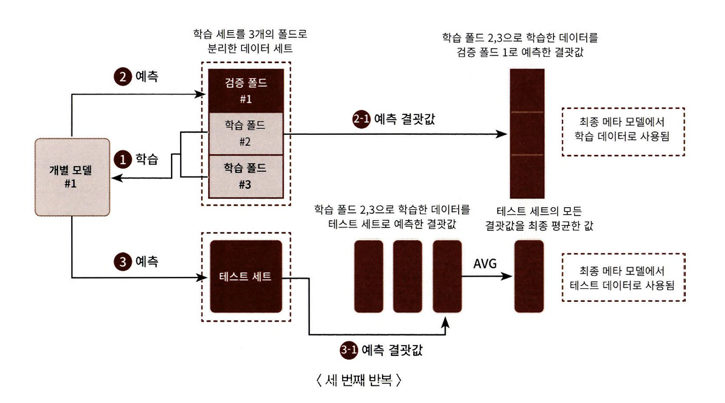

In [79]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean


In [80]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
RandomForestClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
DecisionTreeClassifier  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
AdaBoostClassifier  model 시작 
	 폴드 세트:  0  시작 


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  1  시작 


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  2  시작 


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  3  시작 


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  4  시작 


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  5  시작 


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


	 폴드 세트:  6  시작 


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [83]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [84]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737


---
### 정리
- 스태깅은 여러 개의 개별 모델들이 생성한 예측 데이터를 기반으로 최종 메타 모델이 학습한 별도의 학습 데이터 세트와 예측할 테스트 데이터 세트를 재생성하는 기법
- 메타 모델이 사용할 학습 데이터 세트와 예측 데이터 세트를 개별 모델의 예측 값들을 스태깅 형태로 결합해 생성하는 데 있음.